In [10]:
#######################################################################
# libaries for 3D modelling
import numpy as np
import matplotlib . pyplot as plt
import segyio
import time
import zarr
import os, sys, getopt

#Devito 
from devito import *
from examples.seismic.model import Model
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic.tti import AnisotropicWaveSolver 
from examples.seismic import demo_model, setup_geometry, AcquisitionGeometry

#configuration['platform'], configuration['compiler'], configuration['language'], configuration['log-level']
#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning this notebook into a python script)
#configuration['platform'] = 'nvidiaX'
#configuration['compiler'] = 'pgcc'
#configuration['language'] = 'openacc'

#(c) using one vCPU
#configuration['platform'] = 'cpu64'     # This is default so no need to run it
#configuration['compiler'] = 'custom'   # This is default so no need to run it
#configuration['language'] = 'C'         # This is default so no need to run it

#(d) using multi-vCPUs with OpenMP
configuration['platform'] = 'cpu64'
configuration['compiler'] = 'custom'
configuration['language'] = 'openmp'

print('Starting the job ... ');

###########################################################################
###########################################################################
###########################################################################

def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " s")
    else:
        print("Toc: start time not set")

###########################################################################
###########################################################################
###########################################################################


Starting the job ... 


In [11]:
###########################################################################
#print('Number of arguments:', len(sys.argv), 'arguments.')
#print('Argument List:', str(sys.argv) )

#shot = int(sys.argv[1])
shot=40;

##########################################################################

In [12]:

AZURE_STORAGE_ACCOUNT_NAME="hugoblobtest12345"
AZURE_STORAGE_ACCESS_KEY="648X7ZKv2sdPFWbzUoBRWiu8igckisHM2mEYZtHD2zj/iBMWIhf8dGa4MQnAhbwu/peI9KB51HZd+ASt+Id1Iw=="
container_name1="seismic"
container_name2="shotdata"

backend='zarr_blob'


In [23]:
###########################################################################
# getting parameters - replace with proper par file reader
# 3D shot modelling from segy input
no=1
figures_on = 1

# input the velocity model
dx = 12.5
dy = 12.5
dz = 12.5

# output the seismic shots
object_name1="OverTrust_True"
object_name2="OverTrust_ShotData"

# 0 - write to blob
output_file = 0

# simulation model size and spacing
model_size = (6000,3000,5000)
spacing = (dx, dx, dz)   # dx dy dz spatial sampling

# shot spacings
dxs = 250
dys = 25
depthS= 20
offsetS = 6000;

# shot times
t0 = 0.     
tn = 4000.  # total time ms
fc = 15/1000  # frequency in kHz
dt = 1
origin = 0, 0, 0
###########################################################################
###########################################################################


In [24]:
#open blob velocity model
#################################################################################
if backend == 'zarr_blob':       
    import azure.storage.blob 
    print('opening input file on blob to process',object_name1)
    
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name1)
    store = zarr.ABSStore(client=container_client, prefix=object_name1)
    root = zarr.group(store=store, overwrite=False)
    vzarr=root
    print('opening velocity model')

elif backend == 'zarr':
    print('opening input file to process',object_name1)
    vzarr = zarr.open(object_name1, mode='r')
    print('opening velocity model')

nilines, nxlines,nsamples = vzarr.volume.shape
nilines, nxlines,nheaders = vzarr.header.shape
ntasks=nilines
print('nil=',nilines, 'nxl=',nxlines, 'ntasks=',ntasks)
nx=nilines
ny=nxlines
nz=nsamples
##############################################################################
#QC of velocity model and sizing
slx=int(nx/2);
sly=int(ny/2)
slz=int(nz/2)


opening input file on blob to process OverTrust_True
opening velocity model
nil= 1600 nxl= 1600 ntasks= 1600


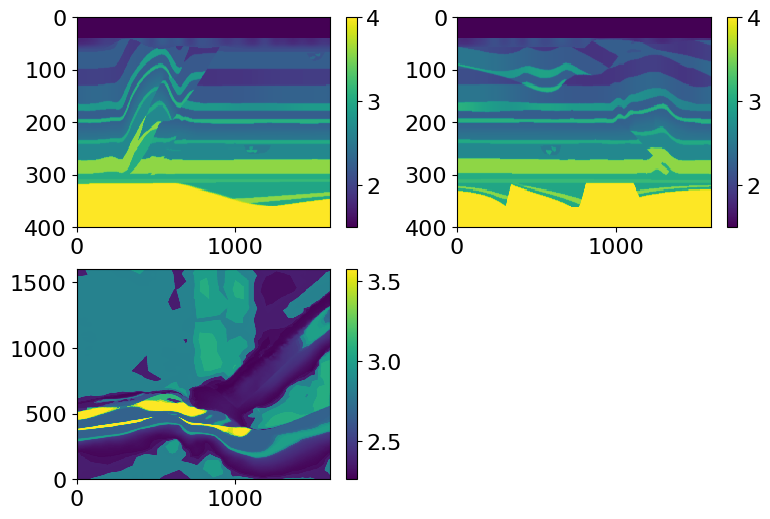

In [25]:
##########################################################################
#QC of velocity model and sizing
if(figures_on==1): 
    
    fig = plt.figure(num=no,figsize=(9, 6)) ;
    plt.clf();
    mm = vzarr.volume[slx,:,:] 
    plt.subplot(221)
    plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
    plt.colorbar();
       
    plt.gca().invert_yaxis()  
    mm = vzarr.volume[:,sly,:] 
    plt.subplot(222)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    plt.gca().invert_yaxis()
    
    mm = vzarr.volume[:,:,slz] 
    plt.subplot(223)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    #plt.savefig('build_overtrust_img1.jpg');
    


input model size in cells (1600, 1600, 400)
simulation model size in cells (480, 240, 400)
source location model [[6250. 7025.   20.]]
source location cell [[500.  562.    1.6]]
#shots 10240


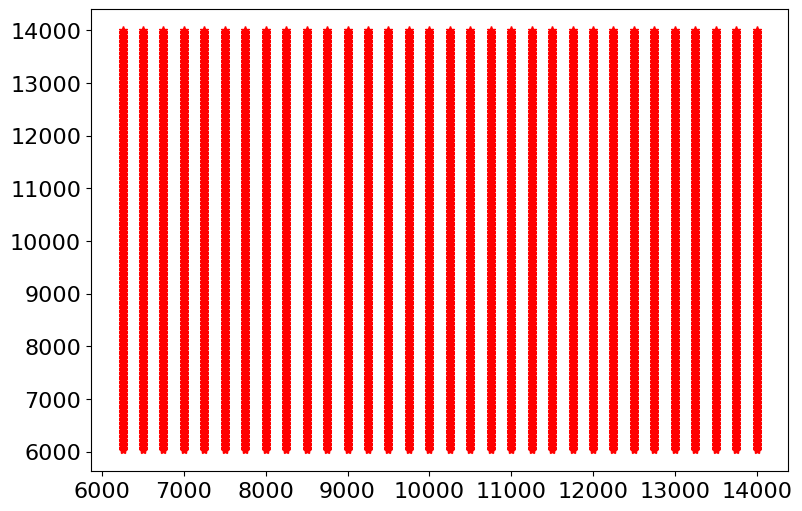

In [26]:
#############################################################################
# Load in local velocity model
shape = (int(model_size[0]/spacing[0]) ,int(model_size[1]/spacing[1]) ,int(model_size[2]/spacing[2]) )
print('input model size in cells',vzarr.volume.shape)
print('simulation model size in cells',shape)
shape_full = vzarr.volume.shape

##############################################################################
# source locations
nshotsX = int((shape_full[0]*dx-2*offsetS)/dxs)   
nshotsY = int((shape_full[1]*dy-2*offsetS)/dys)   
nshots = nshotsX*nshotsY;

src_coordinates0 = np.empty((1, 3)) 
count = 0;
for sx in range(0,nshotsX):
    for sy in range(0,nshotsY):
        if(count == shot):
            src_coordinates0[0,0] = offsetS + dxs + dxs*sx;
            src_coordinates0[0,1] = offsetS + dys + dys*sy;
            src_coordinates0[0,2] = depthS 
        count = count + 1;
print('source location model',src_coordinates0)
print('source location cell',src_coordinates0/spacing)
print('#shots',nshots)

if(figures_on==1): 
   
    src_coordinates1 = np.empty((nshots, 3)) 
    c = 0;
    for sx in range(0,nshotsX):
        for sy in range(0,nshotsY):
            src_coordinates1[c,0] = offsetS + dxs + dxs*sx;
            src_coordinates1[c,1] = offsetS + dys + dys*sy;
            src_coordinates1[c,2] = depthS 
            c = c + 1;
        
    fig = plt.figure(num=no,figsize=(9, 6)) ;
    plt.clf();
    plt.plot(src_coordinates1[:,0],src_coordinates1[:,1],'r*')
    #ss="shot_generate_imgB"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    

In [27]:
#########################################################################
# centre shot location and build model
v1 = np.empty(shape,dtype=np.float32)
xx = src_coordinates0[0,0] - model_size[0]*0.5;
yy = src_coordinates0[0,1] - 0.5*model_size[1];
zz = 0;

src_y=0
src_x=0
if(xx<0):
    src_x=xx;
    xx = 0;
if(yy<0):
    src_y=yy;
    yy = 0;

srcX_orig =  src_coordinates0[0,0];
srcY_orig =  src_coordinates0[0,1];
transX = srcX_orig - model_size[0]*0.5;
transY = srcY_orig - model_size[1]*0.5;

src_coordinates0[0,0] = model_size[0]*0.5;
src_coordinates0[0,1] = 0.5*model_size[1];
src_coordinates0[0,2] = depthS 
##########################################################################
# input specific region of the velocity model
        
xxI = int(xx/spacing[0]);
yyI = int(yy/spacing[1]);
zzI = int(zz/spacing[2]);
v1 = vzarr.volume[xxI:xxI+shape[0],yyI:yyI+shape[1],:]

#########################################################################
# generate locations of recevivers
nrecX=10
nrecY=30
rec_depth=depthS
rec = np.empty((nrecX*nrecY, 3)) 
count = 0;
for sx in range(0,nrecX):
    for sy in range(0,nrecY):
        rec[count,0] = sx*model_size[0]/(nrecX+1) + 0.5*model_size[0]/(nrecX+1);
        rec[count,1] = sy*model_size[1]/(nrecY+1) + 0.5*model_size[1]/(nrecY+1);
        rec[count,2] = rec_depth 
        count = count + 1;
nrec=nrecX*nrecY
##########################################################################

shape= (480, 240, 400)


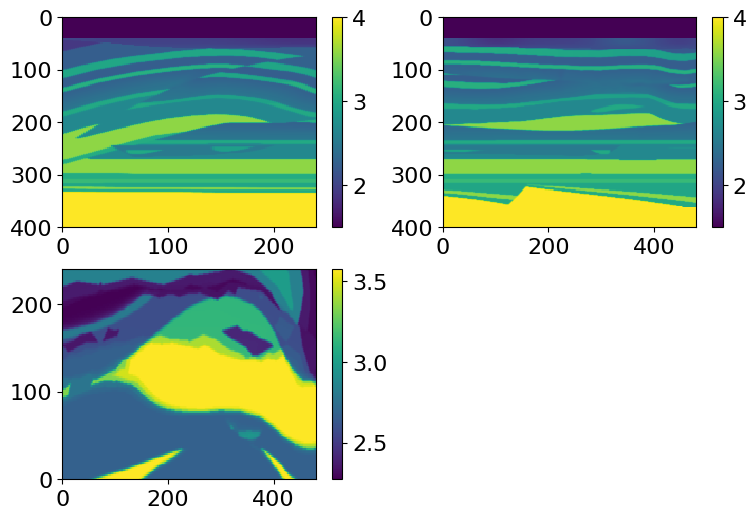

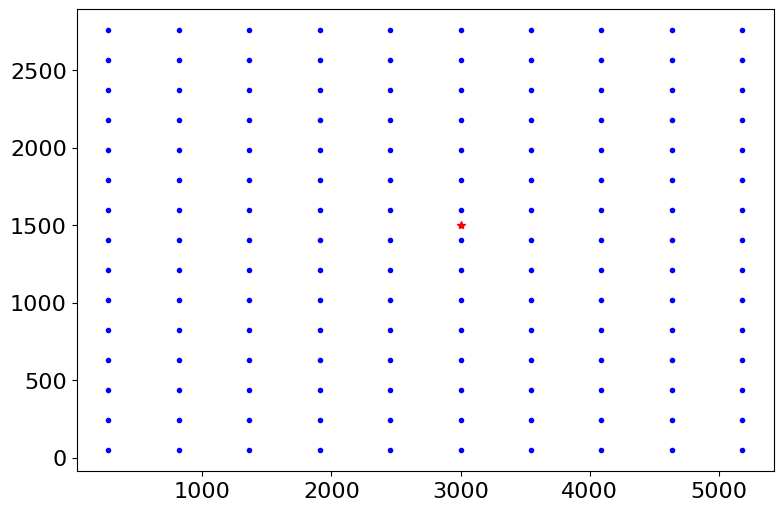

In [28]:
##########################################################################
# output QC plots for model and geometry
nx,ny,nz=v1.shape
shape=v1.shape
print('shape=',shape)
slx=int(nx/2);
sly=int(ny/2)
slz=int(nz/2)

if(figures_on==1):  
    fig = plt.figure(num=no,figsize=(9, 6)) ;
    plt.clf();
    mm = v1[slx,:,:] 
    plt.subplot(221)
    plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
    plt.colorbar();
       
    plt.gca().invert_yaxis()  
    mm = v1[:,sly,:] 
    plt.subplot(222)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    plt.gca().invert_yaxis()
    
    mm = v1[:,:,slz] 
    plt.subplot(223)
    plt.pcolormesh(np.transpose(mm));#, cmap="RdGy")
    plt.colorbar();
    #ss="shot_generate_imgA"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    
    fig = plt.figure(num=no+1,figsize=(9, 6)) ;
    plt.clf();
    plt.plot(src_coordinates0[:,0],src_coordinates0[:,1],'r*')
    plt.plot(rec[::2,0],rec[::2,1],'b.')
    #ss="shot_generate_imgB"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    
##############################################################################

TTI Kernel 


Operator `initdamp` ran in 0.01 s


(480, 240, 400)
(480, 240, 400)


Operator `ForwardTTI` ran in 221.02 s


Ended 
Elapsed time is 227.30119109153748 s


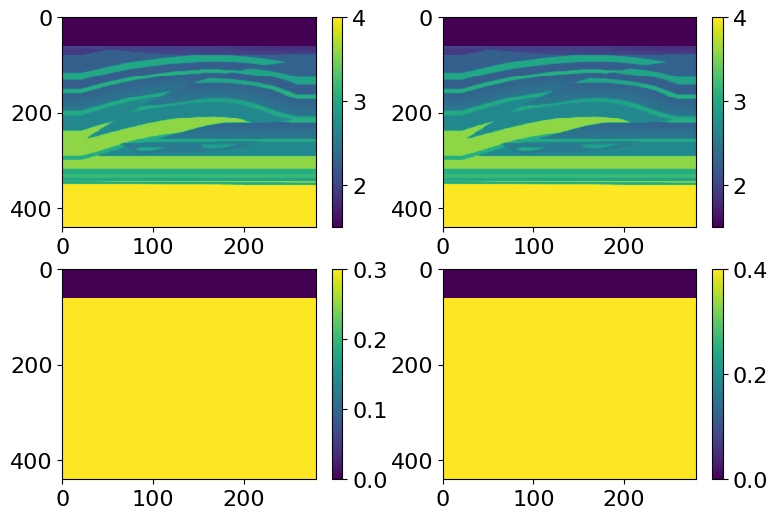

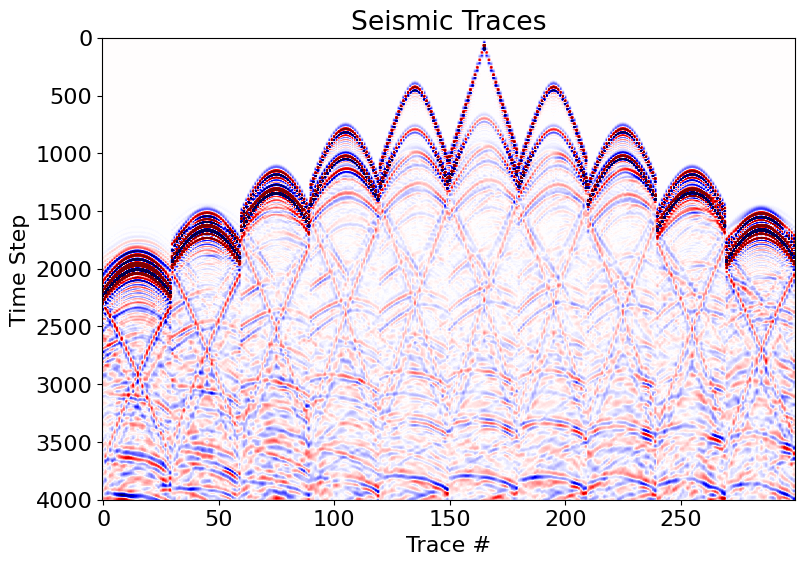

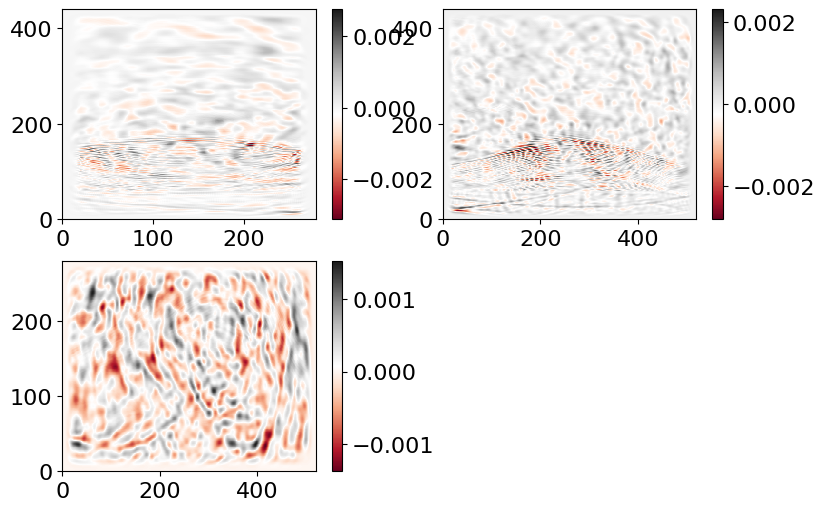

In [29]:
##############################################################################
# starting kernel code taken from ccus_modelling code
# modelling hardcoded parameters
solutionR=2
sp_order=4
nbl=20

if solutionR == 2 :    
    # TTI 
    print('TTI Kernel ')
    
    # update model parameters
    epsilon=np.array(v1)
    epsilon[epsilon <=1.5] = 0
    epsilon[epsilon >1.5] = 0.1

    delta=np.array(v1)
    delta[delta <=1.5] = 0
    delta[delta >1.5] = 0.05
    
    phi=np.array(v1)
    phi[phi <=1.5] = 0
    phi[phi >1.5] = 0.3
    
    theta=np.array(v1)
    theta[theta <=1.5] = 0
    theta[theta >1.5] = 0.4
    
    model = Model(vp=v1, epsilon=epsilon,delta=delta,phi=phi,theta=theta,space_order=4, dtype=np.float32, nbl=nbl,grid=None,shape=shape, origin=origin,spacing=spacing,bcs='damp')
    f0=fc
    print(model.shape)
    print(v1.shape)
    
    if(figures_on==1):  
        fig = plt.figure(num=no+2,figsize=(9, 6)) ;
        plt.clf();
        mm = model.vp.data[slx,:,:] 
        plt.subplot(221)
        plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
        plt.colorbar();          
        plt.gca().invert_yaxis()  
    
        mm = model.vp.data[slx,:,:] 
        plt.subplot(222)
        plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
        plt.colorbar();          
        plt.gca().invert_yaxis()  
        
        mm = model.phi.data[slx,:,:] 
        plt.subplot(223)
        plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
        plt.colorbar();          
        plt.gca().invert_yaxis()  
        
        mm = model.theta.data[slx,:,:] 
        plt.subplot(224)
        plt.pcolormesh(np.transpose(mm) );#, cmap="RdGy")
        plt.colorbar();          
        plt.gca().invert_yaxis()  
        
        #ss="shot_generate_imgC"+str(shot)+".jpeg"
        #plt.savefig(ss,dpi=300);
        
    ####################################################################     
    # build geometry
    geometry = AcquisitionGeometry(model,rec,src_coordinates0,t0,tn,src_type='Ricker',f0=f0,tw0=1.5/f0)
    geometry.resample(dt)
    solver = AnisotropicWaveSolver(model, geometry,spacing=spacing,space_order=sp_order,dt=dt)
    # solver.dt = dt
    # Update source location
    geometry.src_positions[0, :] = src_coordinates0
    # update receiver geometry 
    geometry.rec_positions = rec
    
    tic()
    forward_d, u , w, summary  = solver.forward(dt=dt)
    #forward_d, _ , _, summary  = solver.forward(dt=dt)
    print('Ended ')
    toc()

#t1=time.time()
##############################################################################
##############################################################################
ns=forward_d.data.shape[0]
for i in range (0,ns):
    forward_d.data[i,:] = forward_d.data[i,:] * i * i

if(figures_on==1):
    
    vv = 0.2*np.max(forward_d.data);
    fig = plt.figure(num=no+4,figsize=(9, 6)) ;
    plt.clf();
    #plt.pcolor(forward_d.data,vmin=-vv,vmax=vv,cmap='seismic');
    plt.imshow(forward_d.data,vmin=-vv,vmax=vv,cmap='seismic');
    #plt.gca().invert_yaxis()
    plt.xlabel('Trace #')
    plt.ylabel('Time Step')
    plt.title(r'Seismic Traces')
    ax = plt.gca()
    ax.set_aspect(0.05)
    ss="shot_generate_imgD"+str(shot)+".jpeg"
    plt.savefig(ss,dpi=300);
    
    fig = plt.figure(num=no+5,figsize=(9, 6)) ;
    plt.clf();
    mm = u.data[0][slx,:,:] 
    plt.subplot(221)
    plt.pcolormesh(np.transpose(mm), cmap="RdGy")
    plt.colorbar();
    
    mm = u.data[0][:,sly,:] 
    plt.subplot(222)
    plt.pcolormesh(np.transpose(mm), cmap="RdGy")
    plt.colorbar();
    
    mm = u.data[0][:,:,slz] 
    plt.subplot(223)
    plt.pcolormesh(np.transpose(mm), cmap="RdGy")
    plt.colorbar();
    #ss="shot_generate_imgE"+str(shot)+".jpeg"
    #plt.savefig(ss,dpi=300);
    
##############################################################################


In [ ]:
##############################################################################
if(output_file==0):
    import azure.storage.blob
    container_client = azure.storage.blob.ContainerClient(
        account_name=AZURE_STORAGE_ACCOUNT_NAME,
        credential=AZURE_STORAGE_ACCESS_KEY,
        account_url="https://{}.blob.core.windows.net".format(AZURE_STORAGE_ACCOUNT_NAME),
        container_name=container_name2)
    ppp=object_name2+'_shot'+str(shot)
    print(container_name2)
    print(ppp)
    store = zarr.ABSStore(client=container_client, prefix=ppp) 
    root = zarr.group(store=store, overwrite=True)
    shape_traces=forward_d.shape
    shape_header=nrec, 6  
    tracesOut = root.zeros('tracesOut', shape=shape_traces, compressor='none', dtype=np.float32)
    headerOut = root.zeros('headerOut', shape=shape_header, compressor='none', dtype=np.float32)
    
    headers = np.empty(shape_header,dtype=np.float32)
    for i in range (0,nrec):
        headers[i,0] = shot
        headers[i,1] = srcX_orig
        headers[i,2] = srcY_orig
        headers[i,3] = rec[i,0] + transX
        headers[i,4] = rec[i,1] + transY
        headers[i,5] = dt 

    headerOut[:,:] = headers
    tracesOut[:,:] = forward_d.data
    
##############################################################################    